# Camera

# Imaging a Point Cloud Using a Camera Consructed by Specifying Extrinsic and Intrinsic Parameters

In [1]:
import numpy as np
from plyfile import PlyData, PlyElement
import scipy
import matplotlib.pyplot as plt

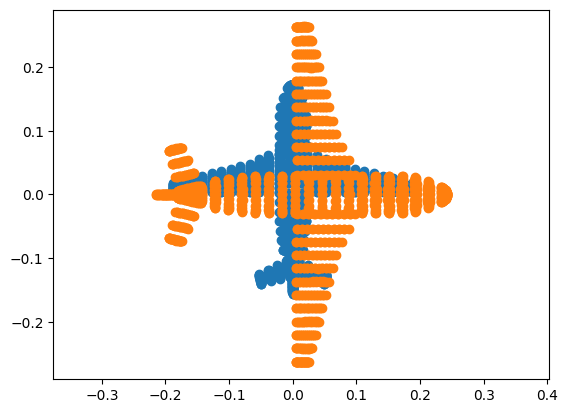

In [26]:
pcd =  PlyData.read(r"images/airplane.ply") # Read the point cloud
points = np.concatenate((pcd['vertex']['x'].reshape(1,-1), pcd['vertex']['y'].reshape(1,-1), pcd['vertex']['z'].reshape(1,-1)), axis=0)
points = points - np.mean(points, axis = 1).reshape(3,1) # Center the points

ones = np.ones((1, points.shape[1]))
points = np.concatenate((points, ones), axis=0) # Add the fourth dimension for homogenous coordinates


P = np.array([[1., 0., 0., 0.], 
              [0., 1., 0., 0.],
              [0., 0., 1., 0.]])

# Rotation matrix R is an orthonormal marix
R = np.array([[1., 0., 0.], 
              [0., 1., 0.],
              [0., 0., 1.]])
K = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [0., 0., 1.]])
t = np.array([[0.],
              [0.],
              [-4000.]])
P1 = np.matmul(K, np.concatenate((R, t), axis=1))# P = K[R|t] = K[R|-RC]

R = np.array([[0., 0.7, 0.], 
              [0.7, 0., 0.],
              [0., 0., 0.7]])
K = np.array([[2., 0., 0.],
              [0., 2., 0.],
              [0., 0., 1.]])
P2 = np.matmul(K, np.concatenate((R, t), axis=1))

fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
transfromed = P1 @ points
transfromed = transfromed/transfromed[2,:]
ax.scatter(transfromed[0,:], transfromed[1,:])

transfromed = P2 @ points
transfromed = transfromed/transfromed[2,:]
ax.scatter(transfromed[0,:], transfromed[1,:])
ax.axis('equal')
plt.show()

Text(0.5, 0, 'z')

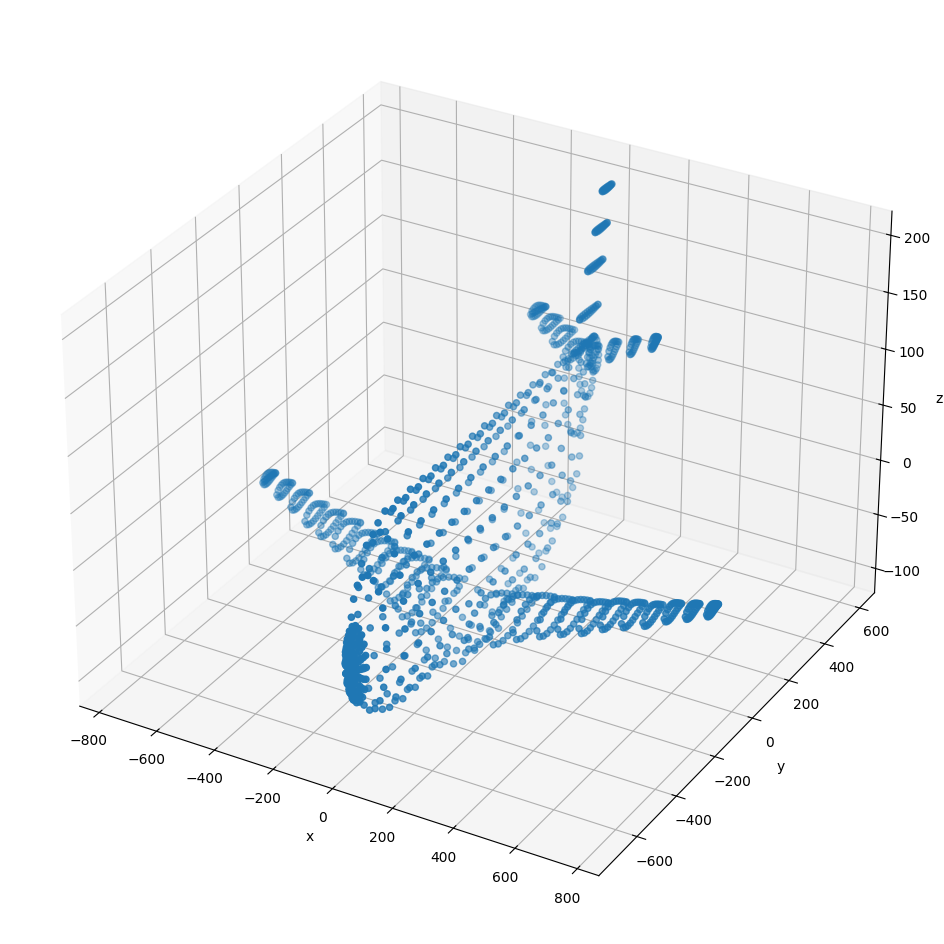

In [27]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(points[0,:], points[1,:], points[2,:])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [28]:
np.set_printoptions(precision=4, suppress=True)
print('P1\n', P1)
print('P2\n', P2)

P1
 [[    1.     0.     0.     0.]
 [    0.     1.     0.     0.]
 [    0.     0.     1. -4000.]]
P2
 [[    0.      1.4     0.      0. ]
 [    1.4     0.      0.      0. ]
 [    0.      0.      0.7 -4000. ]]


### Recovering K, R and C

In [29]:
# RQ Decomposition
# http://ksimek.github.io/2012/08/14/decompose/
def rq(M):
    ''' Here we do QR decomposition, but we want RQ decomposition
    so we do QR decomposition and then transpose the result'''
    Q, R = np.linalg.qr(np.flipud(M).T)
#     print(Q)
#     print(R)
    R = np.flipud(R.T)
    R = np.fliplr(R) 
    Q = Q.T;   
    Q = np.flipud(Q)
    return R, Q

In [31]:
M = P2[:, 0:3]
C = np.linalg.inv(M)@P1[:,3] # camera center in world coordinates
K, R = rq(M)

# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)))

K = K @ T
R = T @ R # (T is its own inverse)
print(K)
print(R)

[[1.4 0.  0. ]
 [0.  1.4 0. ]
 [0.  0.  0.7]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [32]:
# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)))

K = K @ T
R = T @ R # (T is its own inverse)
print(K)
print(R)

[[1.4 0.  0. ]
 [0.  1.4 0. ]
 [0.  0.  0.7]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [33]:
Phz = np.array(
    [[3.53553e+2, 3.39645e+2, 2.77744e+2, -1.44946e+6], 
     [-1.03528e+2, 2.33212e+1, 4.59607e+2, -6.32525e+5],
     [7.07107e-1, -3.53553e-1, 6.12372e-1, -9.18559e+2]])

In [34]:
M = Phz[:, 0:3]
C = -np.linalg.inv(M)@Phz[:,3] # camera center in world coordinates
K, R = rq(M)
# K, R = scipy.linalg.rq(M)

# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)))

K = K @ T
R = T @ R # (T is its own inverse)
print(C)
print(K)
print(R)

# Checking again
P = K @ R @ np.concatenate((np.eye(3), -C.reshape(3,1)), axis=1)
print(P)

[1000.0007 2000.002  1500.0003]
[[468.1647  91.2251 300.    ]
 [  0.     427.2009 199.9999]
 [  0.       0.       1.    ]]
[[ 0.4138  0.9091  0.0471]
 [-0.5734  0.2201  0.7892]
 [ 0.7071 -0.3536  0.6124]]
[[     353.553       339.645       277.744  -1449460.    ]
 [    -103.528        23.3212      459.607   -632525.    ]
 [       0.7071       -0.3536        0.6124     -918.559 ]]


In [36]:
print(np.round(K, 2))
print(np.concatenate((np.eye(3), -C.reshape(3,1)), axis=1))

[[468.16  91.23 300.  ]
 [  0.   427.2  200.  ]
 [  0.     0.     1.  ]]
[[    1.         0.         0.     -1000.0007]
 [    0.         1.         0.     -2000.002 ]
 [    0.         0.         1.     -1500.0003]]


### Camera imaging

Consider a point on a sensor at $(\hat{x}, \hat{y})mm$ with pixel densities $m_x$ and $m_y$ pixels per mm. The pixel number is then given by 
$$ x = m_x \hat{x} $$
and 
$$ y = m_y \hat{y} $$ 
But the origin need not be in the center. It may be in one of the corners. Therefore, the coordinated become:
$$ x = m_x \hat{x} + x_0 $$
and 
$$y = m_y \hat{y} + y_0$$
But $\hat{x}$ and $\hat{y}$ are in the camera coordinate system and they can be written by:
$$\hat{x} = f \frac{X}{Z}$$
and
$$\hat{y} = f \frac{Y}{Z}$$
where $f$ is the focal length of the camera. Therefore, the pixel coordinates become:
$$x = m_x f \frac{X}{Z} + x_0$$
and
$$y = m_y f \frac{Y}{Z} + y_0$$
$f$, $x_o$ and $y_o$ are intrinsic parameters of the camera.

The homogenous 3D coordinate can be represented as:
$$\begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} = \begin{bmatrix} \tilde{w}X \\ \tilde{w}Y \\ \tilde{w}Z \\ \tilde{w} \end{bmatrix}$$

Consider the previous equation. Any pixel coordinates $(u,v)$.

$$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \begin{bmatrix} Zu \\ Zv \\ Z \end{bmatrix} = \begin{bmatrix} fX + Zo_x \\ fY + Zo_y \\ Z \end{bmatrix} = \begin{bmatrix} f_x & 0 & o_x & 0 \\0 & f_y & o_y & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}. \begin{bmatrix}X \\ Y \\ Z \\ 1 \end{bmatrix}$$

The 3x4 matrix is the intrinsic matrix. The first 3x3 matrix is called the calibration matrix which is upper triangular.

Now we are done with mapping the 3d point in camera coordinates to a point in the matrix. Next we need to map the world coordinates to th ecamera coordinates. (3D to 3D). This can be done by the position of the camera coordinates with respect to the world coordintates. This is given by a rotation and translation matrix.
$$R = \begin{bmatrix} r_{11} & r_{12} & r_{13} \\ r_{21} & r_{22} & r_{23} \\ r_{31} & r_{32} & r_{33} \end{bmatrix}$$
The first row gives the direction of camera's x coordinates in the world, second row is for y and 3rd row is for z. The rotation matrix is an orthomormal matrix. We concatenate this with a translation matrix
$$t = \begin{bmatrix}t_x, t_y, t_z \end{bmatrix}$$

To do this in 1 matrix, we use homogenous coordinates
$$\begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \\ 0 & 0 & 0 & 1\end{bmatrix}\begin{bmatrix}X \\ Y \\ Z \\ 1 \end{bmatrix}$$

This matrix is called the extrinsic matrix.

### Camera Calibration

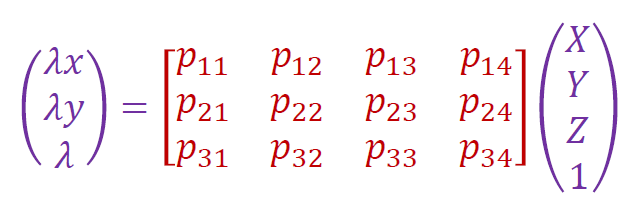

To calibrate we use a known distinctive pattern such as a checkerboard pattern.

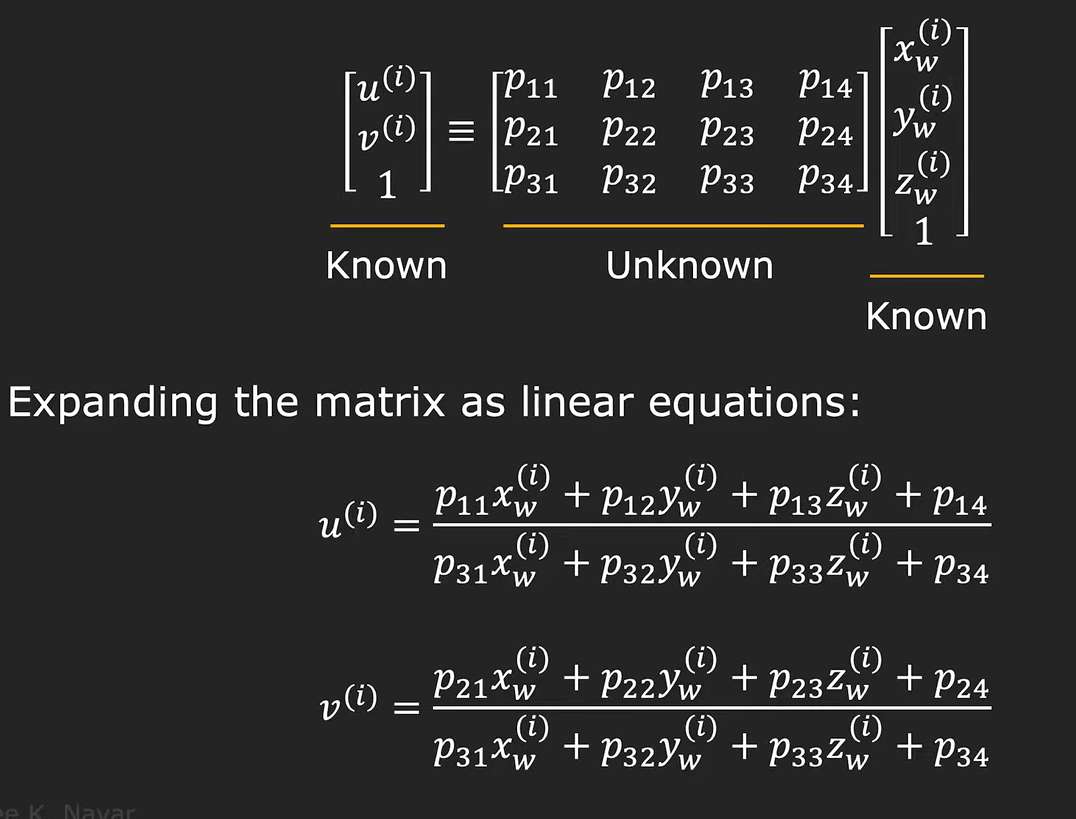

Scaling the projection matrix inplies scaling the world and the camera by the same factor and hence the scale can be arbitrary.

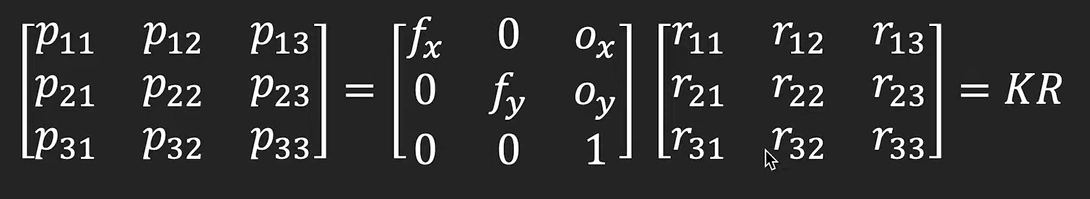

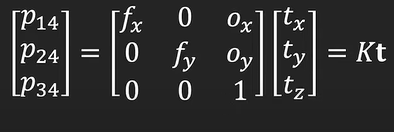

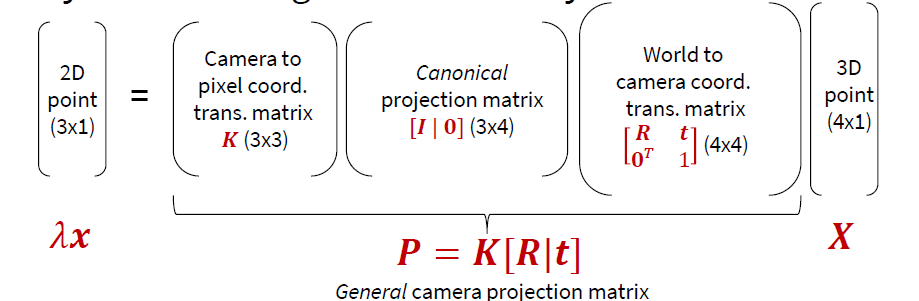